# Module4  : Training and evaluating  Random forest in Cybersecurity                  
                        


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Sources of Cybersecurity Data
Typical sources of data used in cybersecurity include:

In [23]:
# Load a sample from CICIDS2017 (must be downloaded beforehand)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

np.random.seed(43)  # For reproducibility
# Replace with actual path if you have the dataset
logs_df= pd.read_csv("CICIDS2017_sample.csv")
logs_df


ParserError: Error tokenizing data. C error: Expected 78 fields in line 2682, saw 80


## Step 1: Data Profiling

In [ ]:
from scipy import stats  # Import stats from scipy

# Profile the dataset
print("Basic Info:")
print(logs_df.info())

print("\nDescriptive Statistics:")
print(logs_df.describe(include='all'))

print("\nMissing Values:")
print(logs_df.isnull().sum())

print("\nUnique values in each column:")
print(logs_df.nunique())

print("Duplicates:")
print(logs_df.duplicated().sum())


# Select numeric columns only
numeric_cols = logs_df.select_dtypes(include=['float64', 'int64'])

# Calculate Z-scores
z_scores = np.abs(stats.zscore(numeric_cols))

# Count outliers (values with z-score > 7)
outliers = (z_scores > 7)
num_outliers = np.sum(outliers)

print(f"Number of outliers: {num_outliers}")



Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 56580 entries, 0 to 56660
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                56580 non-null  int64  
 1   Total Fwd Packets            56580 non-null  int64  
 2   Total Backward Packets       56580 non-null  int64  
 3   Total Length of Fwd Packets  56580 non-null  int64  
 4   Total Length of Bwd Packets  56580 non-null  int64  
 5   Fwd Packet Length Max        56580 non-null  int64  
 6   Fwd Packet Length Min        56580 non-null  int64  
 7   Fwd Packet Length Mean       56580 non-null  float64
 8   Fwd Packet Length Std        56580 non-null  float64
 9   Bwd Packet Length Max        56580 non-null  int64  
 10  Bwd Packet Length Min        56580 non-null  int64  
 11  Bwd Packet Length Mean       56580 non-null  float64
 12  Bwd Packet Length Std        56580 non-null  float64
 13  Flow Byte

## Step 2: Data Cleaning

In [ ]:
from scipy import stats
import numpy as np

# Replace empty strings and inconsistent protocol names
logs_df.replace("", np.nan, inplace=True)

# Drop rows with critical missing or invalid Flow Duration

logs_df = logs_df[logs_df['Flow Duration'] > 0].dropna(subset=['Flow Duration'])
# Drop rows with critical missing or invalid Total Fwd Packets
df = logs_df[logs_df['Total Fwd Packets'] > 0].dropna(subset=['Total Fwd Packets'])

# Fix missing values in numerical columns by filling with the median
numerical_cols = logs_df.select_dtypes(include=['float64', 'int64']).columns
logs_df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
logs_df.reset_index(drop=True, inplace=True)

# Remove duplicates rows
logs_df = logs_df.drop_duplicates()

# Remove duplicates columns
logs_df = logs_df.T.drop_duplicates().T

logs_df


,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.5,17.67767,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56575,234,2,2,64,232,32,32,32.0,0.0,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56576,133288,2,2,94,482,47,47,47.0,0.0,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56577,11507694,5,4,450,3525,450,0,90.0,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56578,11507707,8,6,416,11632,416,0,52.0,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


## Encode Categorical columns

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize encoder
le = LabelEncoder()

# Encode 'Label' column
if 'Label' in logs_df.columns:
    logs_df['Label'] = le.fit_transform(logs_df['Label'])
logs_df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.5,17.67767,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56575,234,2,2,64,232,32,32,32.0,0.0,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
56576,133288,2,2,94,482,47,47,47.0,0.0,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
56577,11507694,5,4,450,3525,450,0,90.0,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,3
56578,11507707,8,6,416,11632,416,0,52.0,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,3


# Data visualization

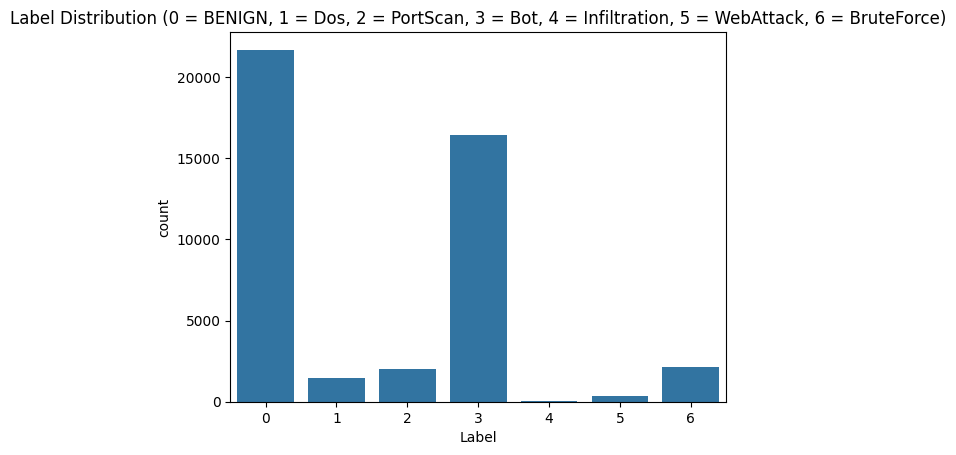

In [ ]:
# Visualize Attack distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Label', data=logs_df).set_title('Label Distribution')
plt.title('Label Distribution (0 = BENIGN, 1 = Dos, 2 = PortScan, 3 = Bot, 4 = Infiltration, 5 = WebAttack, 6 = BruteForce)')
plt.show()

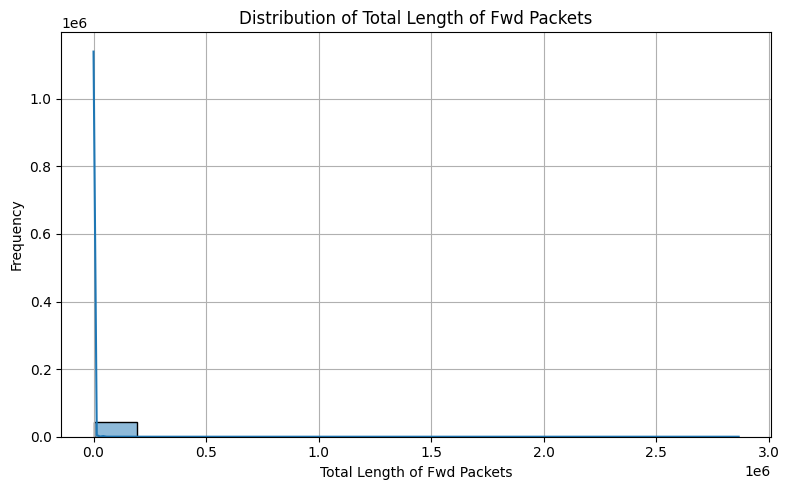

In [ ]:
# Plot the distribution of by Total Length of Fwd Packets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(logs_df['Total Length of Fwd Packets'], bins=15, kde=True)
plt.title('Distribution of Total Length of Fwd Packets')
plt.xlabel('Total Length of Fwd Packets')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

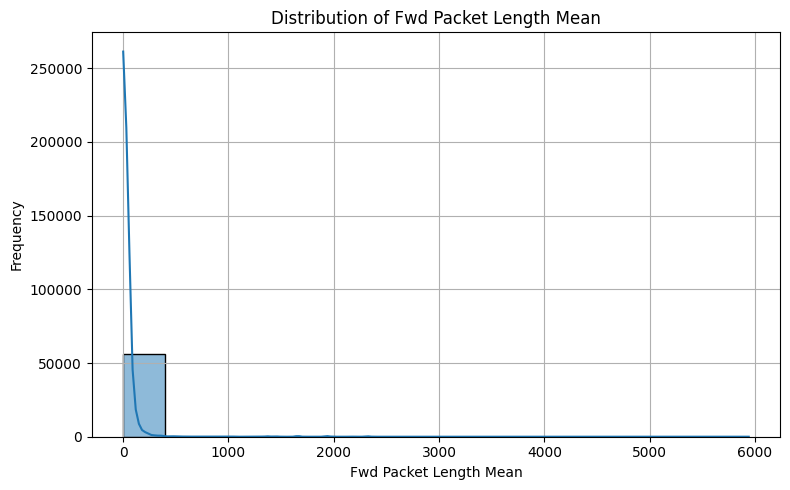

In [ ]:
# Plot the distribution of by Fwd Packet Length Mean
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(logs_df['Fwd Packet Length Mean'], bins=15, kde=True)
plt.title('Distribution of Fwd Packet Length Mean')
plt.xlabel('Fwd Packet Length Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

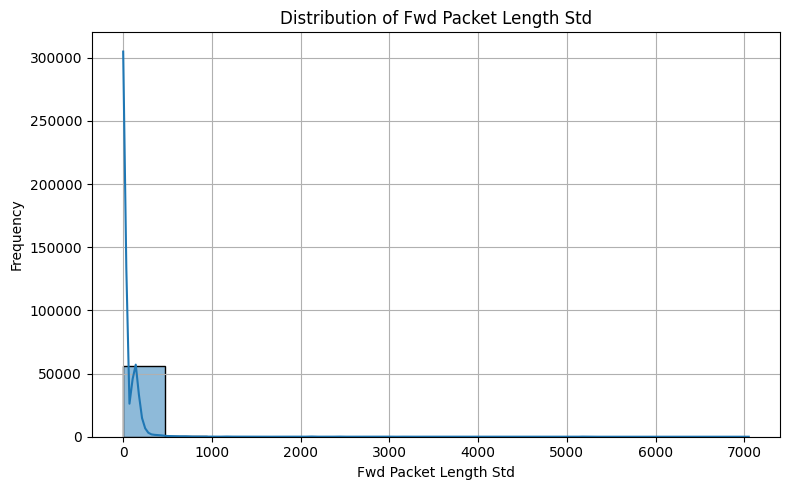

In [ ]:
# Plot the distribution of by Fwd Packet Length Std
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(logs_df['Fwd Packet Length Std'], bins=15, kde=True)
plt.title('Distribution of Fwd Packet Length Std')
plt.xlabel('Fwd Packet Length Std')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

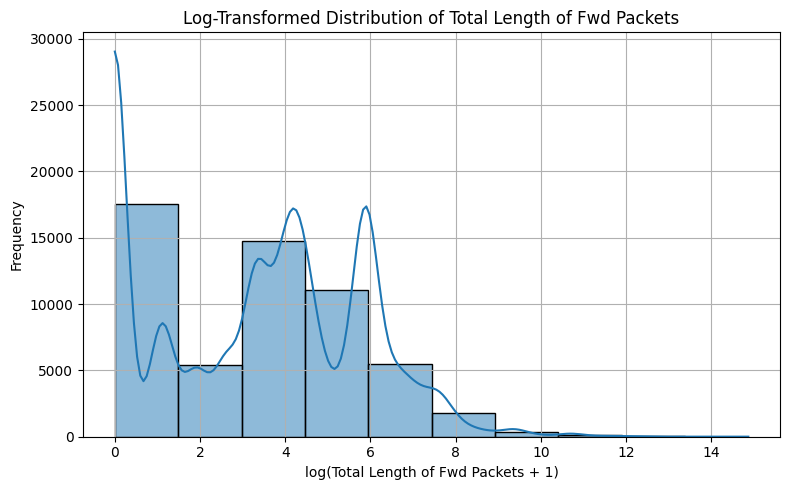

In [ ]:
# Optional: Log-transformed version of the distribution of Total Length of Fwd Packets
plt.figure(figsize=(8, 5))
# Ensure the column is numeric
logs_df['Total Length of Fwd Packets'] = pd.to_numeric(logs_df['Total Length of Fwd Packets'], errors='coerce')

# Drop rows with NaN values in the column (if any)
logs_df = logs_df.dropna(subset=['Total Length of Fwd Packets'])

# Apply log transformation
sns.histplot(np.log1p(logs_df['Total Length of Fwd Packets']), bins=10, kde=True)
plt.title('Log-Transformed Distribution of Total Length of Fwd Packets')
plt.xlabel('log(Total Length of Fwd Packets + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


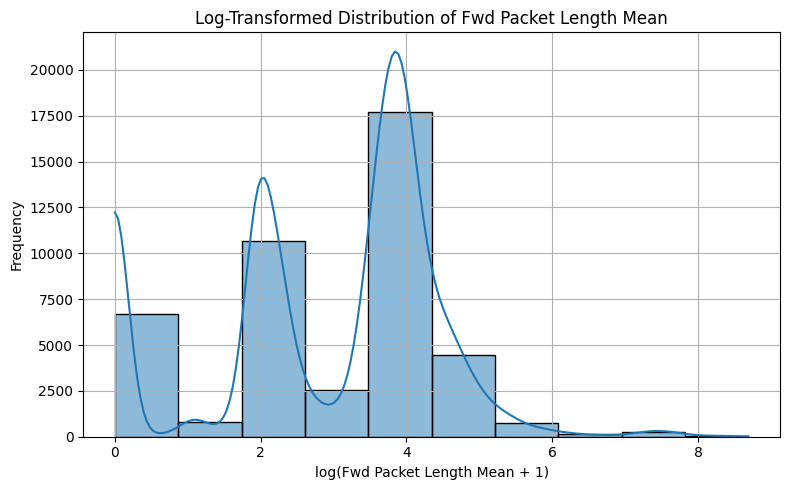

In [ ]:
# Optional: Log-transformed version of the distribution of Fwd Packet Length Mean
plt.figure(figsize=(8, 5))

# Ensure the column is numeric
logs_df['Fwd Packet Length Mean'] = pd.to_numeric(logs_df['Fwd Packet Length Mean'], errors='coerce')

# Drop rows with NaN values in the column (if any)
logs_df = logs_df.dropna(subset=['Fwd Packet Length Mean'])

# Apply log transformation
sns.histplot(np.log1p(logs_df['Fwd Packet Length Mean']), bins=10, kde=True)
plt.title('Log-Transformed Distribution of Fwd Packet Length Mean')
plt.xlabel('log(Fwd Packet Length Mean + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


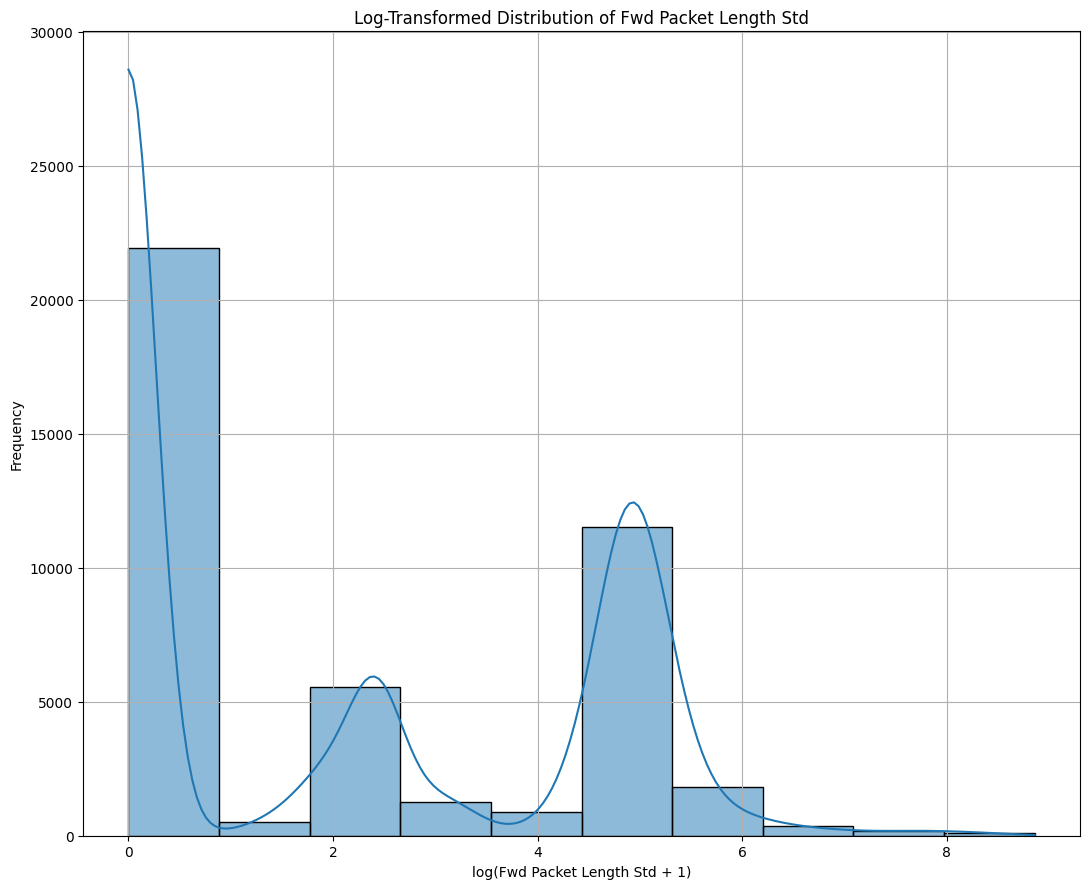

In [ ]:
# Optional: Log-transformed version of the distribution of Fwd Packet Length Std
plt.figure(figsize=(11, 9))
# Ensure the column is numeric
logs_df['Fwd Packet Length Std'] = pd.to_numeric(logs_df['Fwd Packet Length Std'], errors='coerce')

# Drop rows with NaN values in the column (if any)
logs_df = logs_df.dropna(subset=['Fwd Packet Length Std'])

# Apply log transformation
sns.histplot(np.log1p(logs_df['Fwd Packet Length Std']), bins=10, kde=True)
plt.title('Log-Transformed Distribution of Fwd Packet Length Std')
plt.xlabel('log(Fwd Packet Length Std + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 3: Data Transformation and Balancing

In [ ]:
# Convert categorical variables to numeric
df_bal = pd.get_dummies(df, columns=[' Label'])

# Separate features and target
X = df_bal.drop(' Label_BENIGN', axis=1)
y = df_bal[' Label_BENIGN']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE, counts of label '1': {}".format(sum(y_train_balanced==1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_balanced==0)))
#logs_df

NameError: name 'pd' is not defined

## Step 4: Data Reduction

In [ ]:
# Cell 4: Reduce features (example: PCA on numeric fields)
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler

# Ensure the required label columns exist
#if 'Label' in logs_df.columns:
    #logs_df['Label'] = le.fit_transform(logs_df['Label'])  # Encode 'Label' column if not already encoded
    # Create dummy variables for each label category
    #label_dummies = pd.get_dummies(logs_df['Label'], prefix='Lab')
    #logs_df = pd.concat([logs_df, label_dummies], axis=1)

# Update features list to include the correct dummy columns
#features = ['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std',
            #'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
            #'Lab_3', 'Lab_6']  # Replace 'Lab_BruteForce' and 'Lab_DoS' with their corresponding dummy column names
#X = logs_df[features]

# Standardize
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply PCA
#pca = PCA(n_components=6)
#X_pca = pca.fit_transform(X_scaled)

# Add back to dataframe
#logs_df['pca_1'] = X_pca[:, 0]
#logs_df['pca_2'] = X_pca[:, 1]
#logs_df['pca_3'] = X_pca[:, 2]
#logs_df['pca_4'] = X_pca[:, 3]
#logs_df['pca_5'] = X_pca[:, 4]
#logs_df['pca_6'] = X_pca[:, 5]

#logs_df[['pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']] # Display PCA components


## Step 5: Data Enrichment

In [ ]:
# Enrich data by creating new features
#logs_df['Flow Duration (seconds)'] = logs_df['Flow Duration'] / 1e6  # Convert Flow Duration to seconds
#logs_df['Packet Length Ratio'] = logs_df['Total Length of Fwd Packets'] / (logs_df['Total Length of Bwd Packets'] + 1)  # Avoid division by zero
#logs_df['Total Packets'] = logs_df['Total Fwd Packets'] + logs_df['Total Backward Packets']  # Total number of packets
#logs_df['Fwd Packet Length Var'] = logs_df['Fwd Packet Length Std'] ** 2  # Variance of Fwd Packet Length
#logs_df['Bwd Packet Length Var'] = logs_df['Bwd Packet Length Std'] ** 2  # Variance of Bwd Packet Length

# Display enriched data
#logs_df

## Step 6: Data Validation

In [ ]:
# Cell 6: Validate final data

# Ensure numerical_cols is defined
numerical_cols = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets']  # Replace with the correct numerical columns in your dataset

# Fix negative values in numerical columns by replacing them with 0
logs_df[numerical_cols] = logs_df[numerical_cols].clip(lower=0)

# Perform validation checks
assert logs_df.isnull().sum().sum() == 0, "❌ Data contains missing values!"
assert (logs_df[numerical_cols] >= 0).all().all(), "❌ Numerical columns contain negative values!"
assert logs_df['Flow Duration'].min() > 0, "❌ Flow Duration contains non-positive values!"
assert logs_df['Total Fwd Packets'].min() > 0, "❌ Total Fwd Packets contains non-positive values!"
assert logs_df['Total Backward Packets'].min() >= 0, "❌ Total Backward Packets contains negative values!"

print("✅ Data validation passed.")

✅ Data validation passed.


# The main Exercise  Using the same Dataset CICIDS2017_sample.csv

## Step 2: Data Preprocessing

In [ ]:
r=logs_df.isna().sum()
print(r[r>0])

Flow Bytes/s    54
dtype: int64


In [ ]:
logs_df.dropna(inplace=True)

In [ ]:
logs_df.replace(np.inf, np.nan, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
scale=StandardScaler()
le = LabelEncoder()
logs_df['Label'] = le.fit_transform(logs_df['Label'])

In [ ]:
for i in logs_df['Label'].index:
    if logs_df['Label'][i] != 0:
        logs_df['Label'][i] = 1
    else:
        logs_df['Label'][i] =0

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  logs_df['Label'][i] =0
<ipython-input-103-eb1e51e9efd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_df['Label'][i] =0
<ipython-input-103-eb1e51e9efd9>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a 

In [ ]:
logs_df['Label']

,Label
0,0
1,0
2,0
3,0
4,0
...,...
56656,0
56657,0
56658,1
56659,1


## Step 3: Splitting the Dataset

In [ ]:

# Splitting into training, validation, and test sets

from sklearn.model_selection import train_test_split

X = logs_df.drop(columns=['Label'])  # Features
y = logs_df[['Label']]  # Target variable

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (16974, 77), Validation set: (7921, 77), Test set: (31685, 77)


In [ ]:
y_train.value_counts()

,count
Label,
1,10158
0,6816


## Step 4: Training and Evaluating Random Forest